# Simple Quantum Implementation using Qiskit Aqua for Boolean satisfiability problems



This Jupyter notebook demonstrates how easy it is to use quantum algorithms from [Qiskit Aqua](https://qiskit.org/aqua) to solve Boolean satisfiability problems [(SAT)](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem). 

It is based on the Qiskit tutorial [Using Grover search for 3-SAT problems](https://github.com/Qiskit/qiskit-tutorials/blob/master/community/aqua/optimization/grover.ipynb) by [Jay Gambetta](https://github.com/jaygambetta) and [Richard Chen](https://github.com/chunfuchen) and a hands-on workshop by David Mesterhazy.

Implemented by [Jan-R. Lahmann](http://twitter.com/JanLahmann) using Qiskit, binder and RISE.

## Boolean Satisfiabilty problems (SAT)

The Boolean satisfiability problem [(SAT)](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem) considers a Boolean expression with N boolean variables involving negation (NOT, $\neg$), conjunction (AND, $\wedge$) and disjunction (OR, $\vee$), as in the following (simple) example:  
$$ f(x_1, x_2) = (x_1 \vee x_2) \wedge (x_1 \vee \neg x_2) . $$

The problem is to determine whether there is any assignment of values (TRUE, FALSE) to the Boolean variables which makes the formula true. 

It's something like trying to flip a bunch of switches to find the setting that makes a light bulb turn on.  
SAT is of central importance in many areas of computer science, including complexity theory, algorithmics, cryptography, artificial intelligence, circuit design, and automatic theorem proving.

SAT was the first problem proven to be NP-complete.  
This means that all problems in the [complexity class NP](https://en.wikipedia.org/wiki/NP_(complexity)) are at most as difficult to solve as SAT. 

There is no known classical algorithm that efficiently solves each SAT problem, and it is generally believed that no such algorithm exists.  
Whether Boolean satisfiability problems have a classical algorithm that is polynomial in time is equivalent to the [P vs. NP problem](https://en.wikipedia.org/wiki/P_versus_NP_problem).  


While [Grover's quantum search algorithm](https://en.wikipedia.org/wiki/Grover's_algorithm) does not provide exponential speed-up to this problem, it may nevertheless provide some speed-up in contrast to classical black-box search strategies.



### Basic definitions and terminology


A *literal* is either a variable, or the negation of a variable.  
A *clause* is a disjunction (OR, $\vee$) of literals, or a single literal.  
A formula is in *conjunctive normal form* [(CNF)](https://en.wikipedia.org/wiki/Conjunctive_normal_form) if it is a conjunction (AND, $\wedge$) of clauses, or a single clause.  

A problem in conjunctive normal form is called *3-SAT* if each clause is limited to at most three literals.  
3-SAT is also NP-complete.

Example for 3-SAT: $ (x_1 ∨ ¬x_2) ∧ (¬x_1 ∨ x_2 ∨ x_3) ∧ ¬x_1 $.


## Solving 3-SAT using Qiskit Aqua 

We will show how to solve a 3-SAT problem using quantum algorithms from [Qiskit Aqua](https://qiskit.org/aqua).

Let us consider three Boolean variables $x_1, x_2, x_3$ and a Boolean function $f$ given by:

\begin{align*} 
f(x_1, x_2, x_3) \;= &\;\;\;\;
\;(\neg x_1 \vee \neg x_2 \vee \neg x_3)  \\
&\;\; \wedge \; ( x_1 \vee \neg x_2 \vee  x_3) \\
&\;\; \wedge \;( x_1 \vee  x_2 \vee \neg x_3) \\
&\;\; \wedge \;( x_1 \vee \neg x_2 \vee \neg x_3) \\
&\;\; \wedge \;(\neg x_1 \vee  x_2 \vee  x_3) 
\end{align*}


It is common, to state 3-SAT problems in [DIMACS CNF format](https://people.sc.fsu.edu/~jburkardt/data/cnf/cnf.html):

1. The file may begin with comment lines. 
* The "problem" line begins with "p", followed by the problem type "cnf", the number of variables and the number of clauses.
* The remainder of the file contains lines defining the clauses.
* A clause is defined by listing the index of each positive literal, and the negative index of each negative literal. 



In [1]:
# import Qiskit quantum libraries
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover
from qiskit.circuit.library import PhaseOracle
from qiskit import Aer
from qiskit.algorithms import AmplificationProblem

In [2]:
# import the problem in DIMACS CNF format
import os
import wget
if not '3sat3-5.cnf' in os.listdir():
    wget.download('https://raw.githubusercontent.com/Qiskit/qiskit-tutorials/master/community/aqua/optimization/3sat3-5.cnf')
with open('3sat3-5.cnf', 'r') as f:
    sat_cnf = f.read()
    oracle = PhaseOracle.from_dimacs_file("3sat3-5.cnf")
print(sat_cnf)

c This is an example DIMACS 3-sat file with 3 satisfying solutions: 1 -2 3 0, -1 -2 -3 0, 1 2 -3 0
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0



To apply a quantum algorithm from Qiskit Aqua to this problem, we simply need to import the Qiskit libraries and run the algorithm with the appropriate parameters.

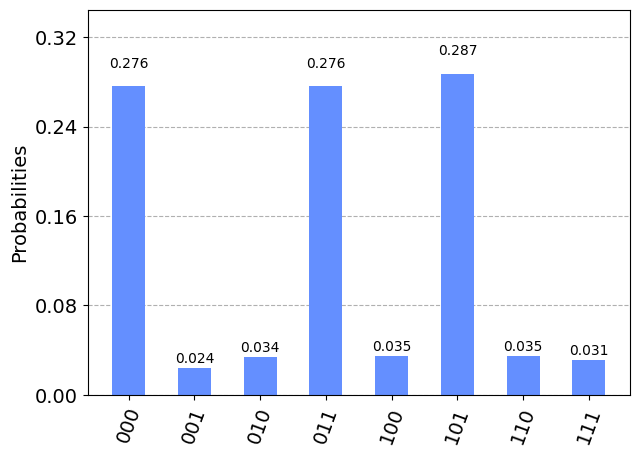

In [3]:
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=200)
grover = Grover(quantum_instance=backend)
problem = AmplificationProblem(oracle)
result = grover.amplify(problem)
plot_histogram(result.circuit_results)

The result shows that the assignments $000, 101, 110$ for $x_1 x_2 x_3$ are potential solutions to the problem.  
Whether these are correct solutions to the problem can be verified efficiently, as 3-SAT is in NP.
Note that the variables in the histogram are in reverse order: $x_3, x_2, x_1$ instead of $x_1, x_2, x_3$.


## Classical brute force algorithm

The solutions to the problem can also be derived with a classical (non-quantum) algorithm by simply trying every possible combination of input values $x_1, x_2, x_3$of $f$.

We find again, that the solutions for the given 3-SAT problem are the assignments $000, 101, 110$ for $x_1 x_2 x_3$.  

In [4]:
from IPython.display import HTML, display
import tabulate

nbr = 3 # number of Boolean variables in Boolean function

table = []
for i in range(2**nbr):
    x1, x2, x3 = [int(x) for x in '{0:03b}'.format(i)] # Boolean variables
    
    # define clauses 
    c1 = [not x1, not x2, not x3] # -1 -2 -3
    c2 = [    x1, not x2,     x3] #  1 -2  3
    c3 = [    x1,     x2, not x3] #  1  2 -3
    c4 = [    x1, not x2, not x3] #  1 -2 -3
    c5 = [not x1,     x2,     x3] # -1  2  3
    
    f = all([any(c1), any(c2), any(c3), any(c4), any(c5)]) # Boolean function
    table.append([x1, x2, x3, f])
    
display(HTML(tabulate.tabulate(table, tablefmt = 'html', 
            headers = ['$x_1$', '$x_2$', '$x_3$', '$f$'])))

$x_1$,$x_2$,$x_3$,$f$
0,0,0,True
0,0,1,False
0,1,0,False
0,1,1,False
1,0,0,False
1,0,1,True
1,1,0,True
1,1,1,False


Remark: this is obviously not the most efficient classical algorithm that exists. Heuristic SAT-algorithms are able to solve problem instances involving tens of thousands of variables and formulas consisting of millions of symbols, which is sufficient for many practical SAT problems.